In [1]:
# 2023 Gabriel J. Diaz @ RIT
import os

os.chdir('../')

import sys
import numpy as np

import logging
import pickle
from tqdm import tqdm

import scipy.signal as signal

import io
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path, PurePath

import sys

import h5py

from flow_source import *

from collections import deque


logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [2]:
plt.rcParams['figure.figsize'] = [640/50., 480 /50.]

In [3]:
a_file_path = os.path.join("D:\\", "Data", "Driving_1","Aware-AI","CM")
source = pupil_labs_source(a_file_path, session_number='S001', recording_number='000')

### If needed, calculate flow and save out to hdf5.

Commented out for now, because this is a slow process that only needs to be done once.
Enabling gpu support is a troublesome process in itself.  Yes, it will run on CPU, but it's slooow.

In [4]:
# source.calculate_flow(algorithm='nvidia2',
#                           preprocess_frames = True,
#                           gaze_centered = False,
#                           save_input_images=False,
#                           save_output_images=False)

## Load in a world video and import optic flow from hdf5

In [5]:
# Define the video
# p = r'D:\Data\Driving_1\Aware-AI\CM\001\PupilData\000\exports\000\world_nvidia2_gaze-centered_hsv.mp4'
world_video = cv2.VideoCapture(source.world_video_path)
print( f'Number of video frames: {int(world_video.get(cv2.CAP_PROP_FRAME_COUNT))}' )

Number of video frames: 14428


In [6]:
flow = source.open_hdf5_file(algorithm='nvidia2', gaze_centered = False)['flow']
print( f'Number of flow frames: {len(flow)}' )

Number of flow frames: 14428


### Overlay optic flow on a frame of video
I only plot every nth vector.  This is set in plot_flow_overlay(skippts=10).
Notice that the dense flow is calculated per-pixel.  A vector is assigned even if there are no image features /
texture elements at that location.  Later in this notebook, I demonstrate how to filter so that this isn't the case.

In [7]:
# Plot flow
def crop_image(bgr_image,win_size):
    
    # crops off the bad OF estimation from the outer parts of the image
    h = np.shape(bgr_image)[0]
    w = np.shape(bgr_image)[1]

    # width of analysis window in proportions of image width/height

    b = int(h/2 + (win_size*h)/2)
    t = int(h/2 - (win_size*h)/2)
    l = int(w/2 - (win_size*w)/2)
    r = int(w/2 + (win_size*w)/2)

    sm_image = bgr_image[t:b,l:r,:]

    return sm_image

def plot_flow_overlay(image_in, flow_in, crop_to=0.8, skippts=5,scale=1, scale_units = 'width',width=.008, return_image = False):
    
    dpi = 100
    fig, ax = plt.subplots()
    
    canvas = FigureCanvas(fig)
    ax.margins(0)

    if crop_to:
        image_in = crop_image(image_in,crop_to)
        flow_in = crop_image(flow_in,crop_to)
    
    s = slice(None,None,skippts)
    
    xmax=np.shape(image_in)[1]
    xpoints = int(np.shape(image_in)[1])
    x=np.linspace(0,np.shape(image_in)[1],xmax)

    ymax=np.shape(image_in)[0]
    ypoints = int(np.shape(image_in)[0])
    y=np.linspace(0,np.shape(image_in)[0],ymax)

    x = x[s]
    y = y[s]
    x2d,y2d=np.meshgrid(x,y,indexing='xy')

    u = -flow_in[...,0]
    v = flow_in[...,1]
    
    u = (u[s,s]/255) * scale
    v = (v[s,s]/255) * scale

#     mag = np.sqrt(u**2 + v**2)
#     xs, ys = np.where( mag > 1)

    plt.imshow(cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB))
    ax.axis('off') 
    
    plt.quiver(x2d,y2d,u,v,color='white', alpha=0.7, width=width,scale = scale,
                  scale_units = 'inches')
        
    if return_image:
        
        canvas.draw()  # draw the canvas, cache the renderer
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,)) 
        return cv2.cvtColor(image_from_plot, cv2.COLOR_BGR2RGB)
    

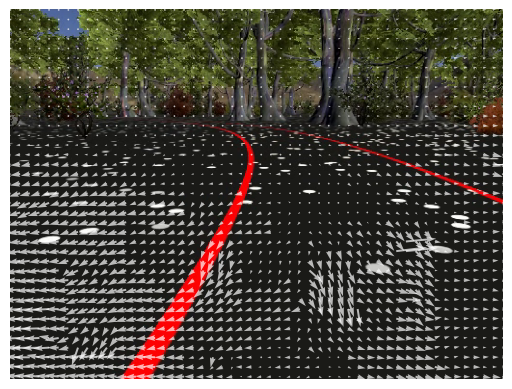

In [8]:
w_f = 4400
f_f = w_f

plt.rcParams['figure.figsize'] = [640/100., 480 /100.]
world_video.set(cv2.CAP_PROP_POS_FRAMES, w_f)
world_success, bgr_world = world_video.read()

# Showing only the central crop_to=0.8 of the image, b/c there is typically noise at the edges. 
# THis is an issue with the nvidia2 optical flow algo.
# Also note that I mask the sky, red road edges, and black portion of the ground plane from 
# the images sent to the optical flow estimator ...but not from the output.  THe estimator tries to fill in the blank regions.
# I recommend masking again, because this is adding information that just isn't in the image.

plot_flow_overlay(bgr_world, flow[f_f,...], crop_to=0.8, skippts=10, scale=10,scale_units = 'width',width=.004)

### Overlay an accumulation of optic flow (sum over an N frame buffer)

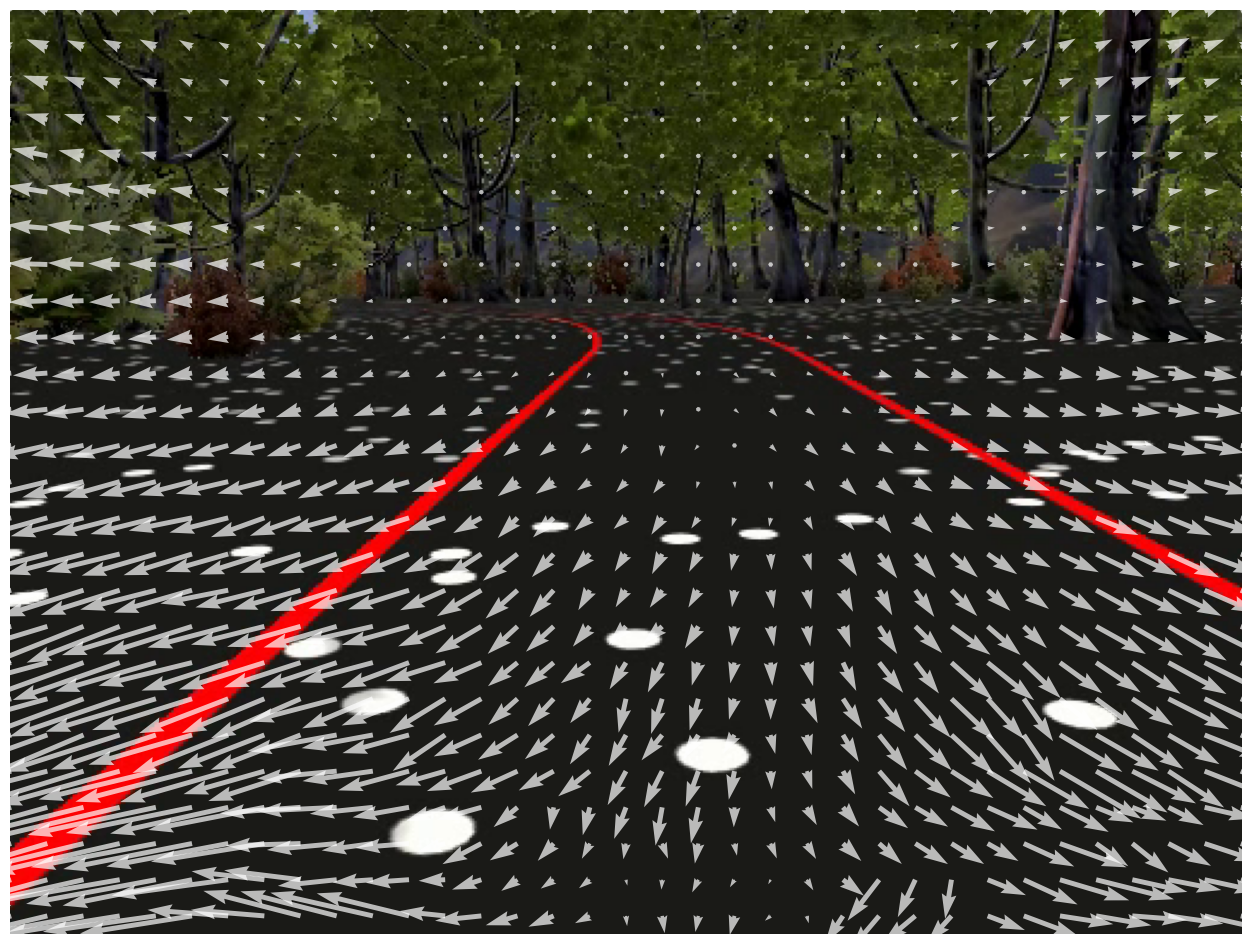

In [9]:
f = 3500

# Integrate flow from n-buffer_len to n (the displayed frame)
buffer_len = 5

start_frame = f
end_frame = start_frame + buffer_len

world_video.set(cv2.CAP_PROP_POS_FRAMES, f)

plt.rcParams['figure.figsize'] = [640/40., 480/40.]

flow_fr_y_x_uv = []

flow_buffer = deque([] * buffer_len)
div_time = []

cv2.destroyAllWindows()

frame_num = f

world_success = True
while world_success:
    
    world_success, bgr_world = world_video.read()
    
    flow_buffer.appendleft(flow[frame_num,...])
 
    flow_fr_y_x_uv.append(flow)

    if frame_num >= end_frame:
        world_success = False

    frame_num = frame_num + 1

cv2.destroyAllWindows()

combined_flow = np.sum(flow_buffer,axis=0)
combined_flow = cv2.blur(combined_flow,[7,7])
plot_flow_overlay(bgr_world, combined_flow, crop_to=0.8, skippts=15, scale=1,scale_units = 'width',width=.004)

### Convert flow to magnitude and angle.  Filter, and plot.

In [10]:
def visualize_flow_as_vectors(frame, magnitude, angle, divisor=15):

    '''Display image with a visualisation of a flow over the top.
    A divisor controls the density of the quiver plot.'''

    # create a blank mask, on which lines will be drawn.
    mask = np.zeros([np.shape(frame)[0], np.shape(frame)[1], 3], np.uint8)

    vector_x, vector_y = cv2.polarToCart(magnitude, angle)

    for r in range(1, int(np.shape(frame)[0] / divisor)):
        for c in range(1, int(np.shape(frame)[1] / divisor)):
            origin_x = c * divisor
            origin_y = r * divisor

            endpoint_x = int(origin_x + vector_x[origin_y, origin_x])
            endpoint_y = int(origin_y + vector_y[origin_y, origin_x])

            mask = cv2.arrowedLine(mask, (origin_x, origin_y), (endpoint_x, endpoint_y), color=(0, 0, 255),
                                   thickness=3, tipLength=0.35)

    return cv2.addWeighted(frame, 0.5, mask, 0.5, 0)


def plot_flow_mag_angle(image_in, magnitude,angle, crop_to=0.8, skippts=5,scale=1, scale_units = 'width',width=.008, return_image = False):
    
    dpi = 100
    fig, ax = plt.subplots()
    
    canvas = FigureCanvas(fig)
    ax.margins(0)

#     if crop_to:
#         image_in = crop_image(image_in,crop_to)
#         flow_in = crop_image(magnitude,crop_to)
    
    s = slice(None,None,skippts)
    
    xmax=np.shape(image_in)[1]
    xpoints = int(np.shape(image_in)[1])
    x=np.linspace(0,np.shape(image_in)[1],xmax)

    ymax=np.shape(image_in)[0]
    ypoints = int(np.shape(image_in)[0])
    y=np.linspace(0,np.shape(image_in)[0],ymax)

    x = x[s]
    y = y[s]
    x2d,y2d=np.meshgrid(x,y,indexing='xy')

    u = magnitude * np.cos(angle) * -1
    v = magnitude * np.sin(angle)
    
    u = (u[s,s]/255) * scale
    v = (v[s,s]/255) * scale

    plt.imshow(cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB))
    ax.axis('off') 
    
    plt.quiver(x2d,y2d,u,v,color='white', alpha=0.7, width=width,scale = scale,
                  scale_units = 'inches')
        
    if return_image:
        
        canvas.draw()  # draw the canvas, cache the renderer
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,)) 
        return cv2.cvtColor(image_from_plot, cv2.COLOR_BGR2RGB)
    

### Calculate the cumulative distribution of vector magnitudes for the central 2/3 of the video
The image output can be found in the export folder of the optic flow video.


In [11]:
an_ax = source.calculate_magnitude_distribution(algorithm='nvidia2',gaze_centered = True)


Calculating magnitude distribution.


Calculating magnitude distribution.: 100%|██████████████████████████████████████| 241/241 [00:01<00:00, 144.57frames/s]


Magnitude saved to D:\Data\Driving_1\Aware-AI\CM\S001\PupilData\000\exports\000\flow_magnitude_data


In [25]:
### Show the image here, for convenience

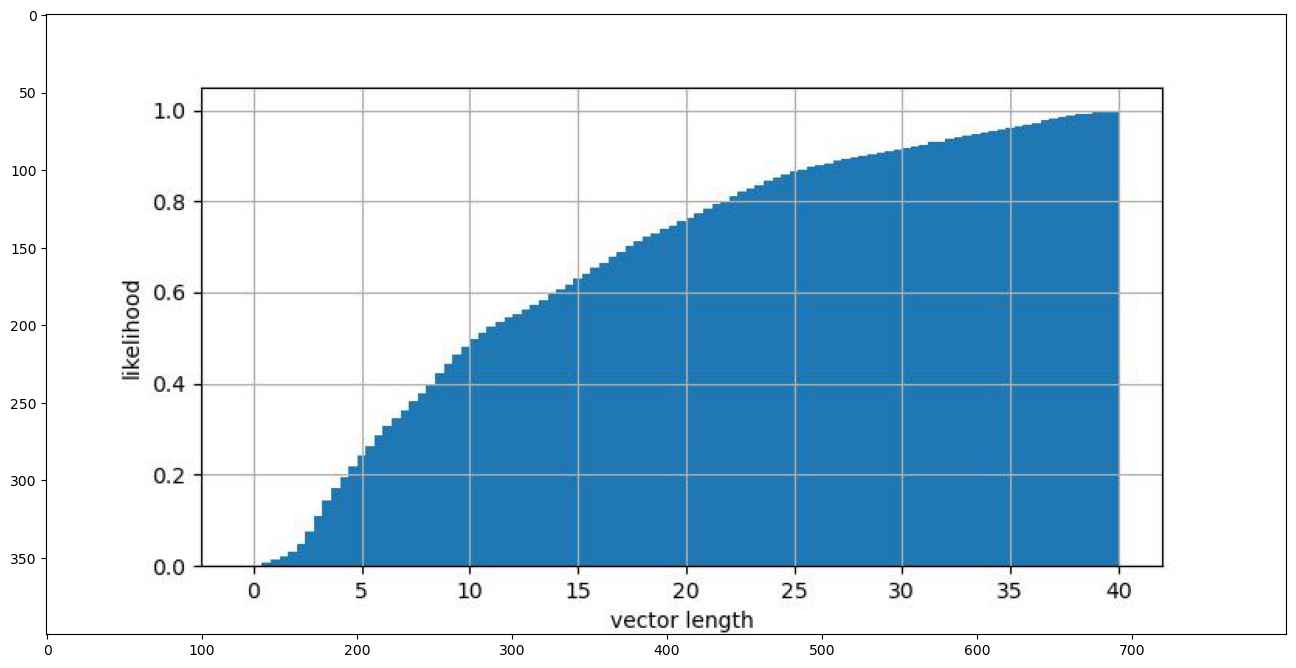

In [26]:
mag_image_filename = source.source_file_name + '_' + 'nvidia2' + '_mag.jpg'
mag_image_fileloc = os.path.join(source.magnitude_out_path, mag_image_filename)

%matplotlib inline
im = plt.imread(mag_image_fileloc);
plt.imshow(im)

### Show an image after converting to magnitude/angle and filtering

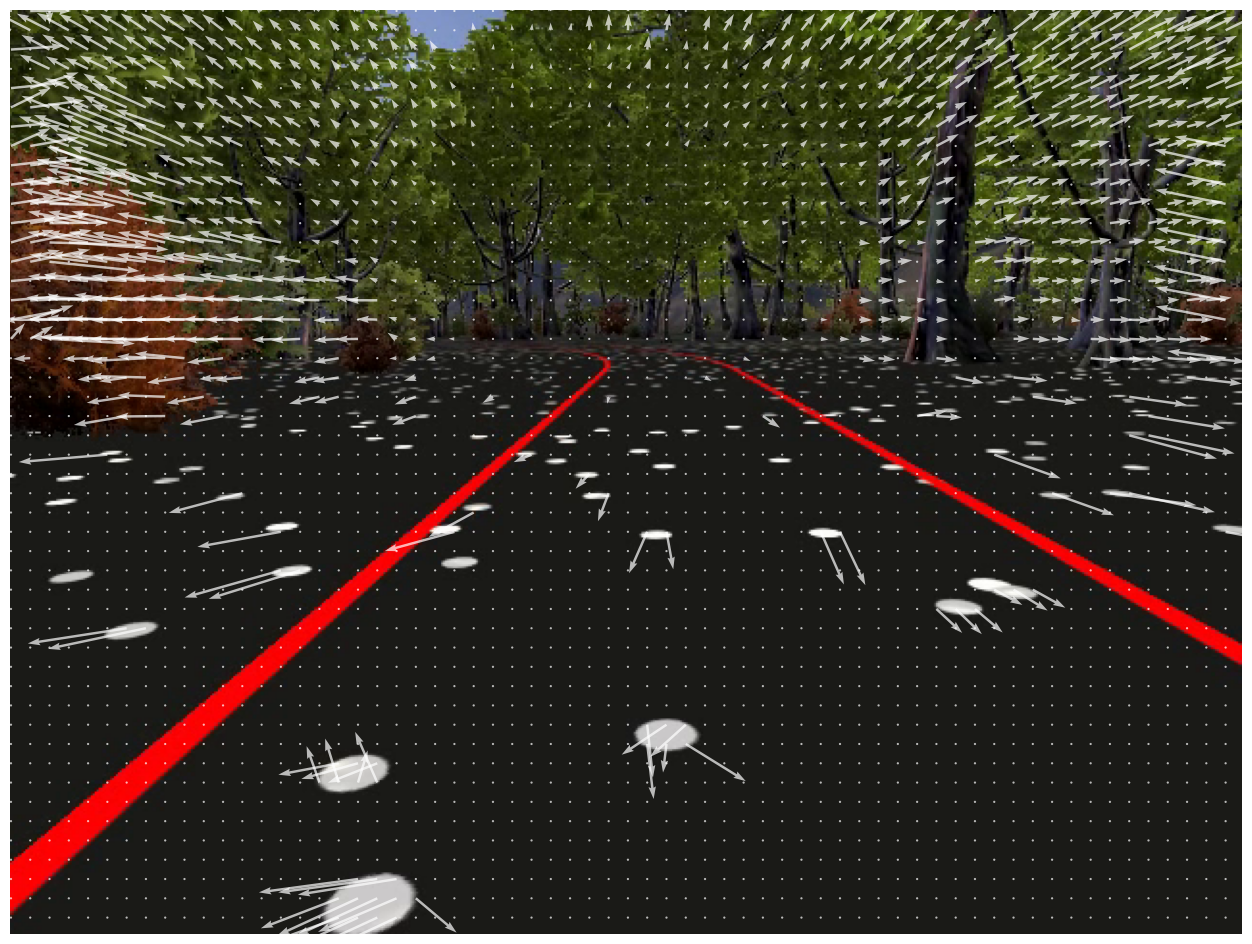

In [35]:

frame_num = 3500

world_video.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
world_success, bgr_world = world_video.read()

# Dense optic flow algorithms like NVidia2 try to estimate flow for each pixel.  
# This is an realistically dense representation.  
# to enforce spatial sparsity, we mask the magnitude and angle. 
# I also allow the person to 
# Compare this with the frame above!

magnitude, angle = source.convert_flow_to_magnitude_angle(flow[frame_num,...], 
                                                   bgr_world,
                                                   lower_mag_threshold=2,
                                                   upper_mag_threshold=35
                                                  )
    
plot_flow_mag_angle(bgr_world, 
                    magnitude,
                    angle,
                    skippts=10,
                    width=0.002)


### Play an animated sequence using magnitude-filtered flow
This opens another window that may not get focus of your OS - check the taskbar after running. 
Hit 'Q' to interrupt playback.

Note that I am only showing every "skippts" vector (an argin to plot_flow_mag_angle() ), and that I am scaling the magnitude of each vector by 0.5

In [43]:
plt.ioff() # stop inline images

f = 5000
play_for_frames = 1000

# Integrate flow from n-buffer_len to n (the displayed frame)
buffer_len = 10

start_frame = f
end_frame = start_frame + play_for_frames

world_video.set(cv2.CAP_PROP_POS_FRAMES, f)

plt.rcParams['figure.figsize'] = [640/40., 480/40.]

flow_buffer = deque([], maxlen=buffer_len)
div_time = []

cv2.destroyAllWindows()

frame_num = f

world_success = True
while world_success:
    
    world_success, bgr_world = world_video.read()
    
    flow_buffer.appendleft(flow[frame_num,...])

    if frame_num >= end_frame:
        world_success = False

    frame_num = frame_num + 1
    
    
    combined_flow = np.sum(flow_buffer,axis=0)
    combined_flow = cv2.blur(combined_flow,[7,7])
    
    magnitude, angle = source.convert_flow_to_magnitude_angle(combined_flow, 
                                                   bgr_world,
                                                   lower_mag_threshold=2,
                                                   upper_mag_threshold=35
                                                  )
    
    im = plot_flow_mag_angle(bgr_world, 
                             magnitude,
                             angle,
                             skippts=7,
                             width=0.002,
                             scale = 0.5,
                             return_image=True)
    
    cv2.imshow("test", np.asarray(im))
    plt.close('all')
        
    if cv2.waitKey(1) & 0xFF == ord('q'):
        plt.ion()
        break
        

cv2.destroyAllWindows()
plt.ion()
